# Switzer method demo
This methodology has not completed WRI's review process and should not be used for any purpose.

Direct questions to Ted Wong (ted.wong@wri.org).

## Problem: How to estimate future probability distributions of climate-hazard indicators
* Data source: climate simulations
    * These are global rasters of CMIP6 simulations. Outputs include daily maxtemp, mintemp, precip, and humidity for every day in years 1950-2100.
    * Downscale product is [NEX-GDDP-CMIP6](https://www.nccs.nasa.gov/services/data-collections/land-based-products/nex-gddp-cmip6). Resolution is 0.25 degrees, or approx. 25 km.
* Additional data: satellite observations
    * This is the [ERA5 reanalysis product](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5), which provides similar variables and resolution for 1940-present.
    * This dataset is not used in the proposed methodology below, but it is available if useful.
    
* Using the simulated variables, for any year we can calculate numerous climate-hazard indicators for any location. Example indicators:
     * Number of days in a year with maxtemp > 35C
     * Duration of longest uninterrupted dryspell in a year
     * Number of degree-days between final frost and first frost in a year
* For a given location and future year, we would like to estimate either...
    * Probability distributions of indicator magnitudes
    * or the probability that the indicator magnitude exceeds a given threshold
* Considerations
    * Ease of calculation
        * Use cases include implementation a a web application for on-demand calculation, and precalculation of large-area rasters. We hope to use methods that lend themselves well to parallelization.
        * We would like to be able to assess the quality of our probability estimates.

## Proposed solution: Random sampling of Poisson rate parameters

* Count exceedance events over a historical interval in both a model and an observation dataset. Also count future exceedance events in one of the climate models.
* Assume counts are Poisson-distributed.
* Using Jeffries prior, the posterior distribution of Poisson rate parameters is Gamma-distributed with shape parameter equal to the event count plus one-half.
* Different models have biases. We'll use the historical observations and historical model data to calibrate each model's future event count. Define a calibration function as follows:
    * Take 10,000 draws from the Gamma distribution using the count from the historical observation dataset as shape parameter. Call these gH_draws.
    * Similar for the historical modeled data: 10,000 draws from Gamma($\alpha$ = historical model count). Call these gHM_draws.
    * Order gH_draws and gHM_draws by size.
    * For j = 1...1000, let X(j,gH) and X(j,gHM) denote the j-th largest value of gH_draws and gHM_draws. Let n(j,gHM) denote the number of gHM sample values that are smaller than X(j,gH). Then the calibrated value of X(j,gHM) is X(n(j),gHM), for j = 1..1000.
    * This defines a mapping from j --> n(j). This mapping is the calibration function.
* Apply the calibration function to gFM_draws to get calibrated gFM_draws, or cgFM_draws. This is the calibrated distribution of Poisson rate parameters.
* Uniformly draw 1000 Poisson parameters from cgFM_draws. Use these 1000 drawn Poisson parameters to generate 1000 Poisson distributions. From each, draw one future exceedance event count.
* Report the mean of the event-count distribution, and display the distribution.
* Do all this for each model and report results separately. Maybe also report the mean value. (Or evaluate models by the distance between gH and gHM, and use only the best model.)




----------------------------------------------------

# Demo implementation

### Import libraries set authentication credentials, etc.

In [1]:
import ee
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

import datetime, calendar

plt.style.use("seaborn-darkgrid")

ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AbUR2VNh9SYjVCsTkfP-0AygIp5UPC390d8fd4Cb_K-Jb8ecdFbPoMFn3_Y

Successfully saved authorization token.


--------------------------
### Select CMIP6 models and define a location and future year of interest

--------------------------------------
### Define indicator of interest
Indicator is **one or more consecutive runs (>= 5 days)  between Apr 15 and Sept 10 with min temp > 25C**

In [2]:
def runs(tf_array, min_runsize, result_type=None):
    falses = np.zeros(tf_array.shape[0]).reshape((tf_array.shape[0],1))
    extended_a = np.concatenate((falses, tf_array, falses), axis=1)
    df = np.diff((extended_a), axis=1)
    starts = np.nonzero(df == 1)
    ends = np.nonzero(df == -1)
    lengths = {i: [] for i in range(tf_array.shape[0] + 1)}
    if starts[0].size > 0:
        for idx in range(starts[0].size):
            length = ends[1][idx] - starts[1][idx]
            if length >= min_runsize:
                lengths[starts[0][idx]].append(ends[1][idx] - starts[1][idx])
        lengths_vals = lengths.values()
    else:
        lengths_vals = []
    result = []
    
    if result_type == 'maxlength':
        for ll in lengths.values():
            if ll:
                result.append(np.max(ll))
            else:
                result.append(0)
    elif result_type == 'minlength':
        for ll in lengths.values():
            if ll:
                result.append(np.min(ll))
            else:
                result.append(0)
    elif result_type == 'meanlength':
        for ll in lengths.values():
            if ll:
                result.append(np.mean(ll))
            else:
                result.append(0)
    elif result_type == 'medianlength':
        for ll in lengths.values():
            if ll:
                result.append(np.median(ll))
            else:
                result.append(0)
    elif result_type == 'count':
        for ll in lengths.values():
            if ll:
                result.append(len(ll))
            else:
                result.append(0)
    else:
        result = lengths
    return result

def dewpoint(T, RH):
# T and Td in deg C
# RH in % (but no need to change from current RH units)
# August-Roche-Magnus approximation
    T = T.astype(np.float64)
    Tmedian = np.median(T)
    if Tmedian >= -40 and Tmedian <= 0:  # https://doi.org/10.1175/1520-0450(1981)020%3C1527:NEFCVP%3E2.0.CO;2
        b = 17.966
        c = 247.15
    elif Tmedian >= -40 and Tmedian <= 50:  # https://doi.org/10.1175/1520-0450(1981)020%3C1527:NEFCVP%3E2.0.CO;2
        b = 17.368
        c = 238.88
    elif Tmedian >= -45 and Tmedian <= 60:  # Sonntag D.: Important New Values of the Physical Constants of 1986, Vapour Pressure Formulations based on the IST-90 and Psychrometer Formulae; Z. Meteorol., 70 (5), pp. 340-344, 1990.
        b = 17.62
        c = 243.12
    else:  # https://doi.org/10.1175/1520-0450(1981)020%3C1527:NEFCVP%3E2.0.CO;2
        b = 18.678
        c = 257.14
    log_rh = np.log(RH.astype(np.float64))
    return c * (log_rh + ((b * T)/(c + T))) / ( b - log_rh - ((b * T)/(c + T)))

def relhum(T, Tdp):
    T = T.astype(np.float64)
    Tdp = Tdp.astype(np.float64)
    numerator = np.exp(17.625 * Tdp / (243.04 + Tdp))
    denominator = np.exp(17.625 * T / (243.04 + T))
    return numerator / denominator

def wetbulbtemp(T, Tdp=None, RH=None):
# JA Knox et al. 2017. Two simple and accurate approximations for wet-bulb
# temperature in moist conditions, with forecasting applications. Bull. Am.
# Meteorol. Soc. 98(9): 1897-1906. doi:10.1175/BAMS-D-16-0246.1
    T = T.astype(np.float64)
    if Tdp is not None:
        Tdp = Tdp.astype(np.float64)
        return (2.0 * T / 3.0) + (Tdp / 3.0)
    else:
        rh_percent = RH.astype(np.float64) * 100
        return T * np.arctan(0.151977 * np.sqrt(rh_percent + 8.313659)) + np.arctan(T + rh_percent) - np.arctan(rh_percent - 1.676331) + ((0.00391838 * ((rh_percent)**(3/2))) * np.arctan(0.023101 * rh_percent)) - 4.686035

indicators = {
    'numdays_temp_lte_0': {
            'name': 'numdays_temp_lte_0',
            'description': 'number of days with min temp <= 0',
            'excluded_models': [],
            'greaterthan': True,
            'variables': [
                  {
                    'nex_varname': 'tasmin',
                    'era5_varname': 'minimum_2m_air_temperature',
                    'nex_conversion': lambda x: x - 273.15,
                    'era5_conversion': lambda x: x - 273.15,
                  }
            ],
            'percentile_variables': [],
            'range': [1, 365, 1],
            'nex_function': lambda windowdata: np.sum(windowdata[0] <= 0, axis=1),
            'era5_function': lambda windowdata: np.sum(windowdata[0] <= 0, axis=1),
            'prob_model': 'binomial'
    },
        'numruns_mintemp_gt_98th_runlength_5': {
            'name': 'numruns_mintemp_gt_98th_runlength_5',
            'description': 'number of runs of 5+ consecutive days with min temp >= local 98th percentile',
            'excluded_models': [],
            'greaterthan': True,
            'variables': [
                  {
                    'nex_varname': 'tasmin',
                    'era5_varname': 'minimum_2m_air_temperature',
                    'nex_conversion': lambda x: x - 273.15,
                    'era5_conversion': lambda x: x - 273.15,
                  }
            ],
            'percentile_variables': [
                  {
                    'percentile': 98,
                    'usemax': True,
                    'nex_varname': 'tasmin',
                    'era5_varname': 'minimum_2m_air_temperature',
                    'nex_conversion': lambda x: x - 273.15,
                    'era5_conversion': lambda x: x - 273.15,
                  }
            ],
            'range': [1, 365, 1],
            'nex_function': lambda windowdata: np.array(runs(windowdata[0] >= windowdata[1], 5, 'count')),
            'era5_function': lambda windowdata: np.array(runs(windowdata[0] >= windowdata[1], 5, 'count')),
            'prob_model': 'poisson'
    },
        'maxrunduration_precip_eq_0': {
            'name': 'maxrunduration_precip_eq_0',
            'description': 'duration in days of longest drought',
            'excluded_models': [],
            'greaterthan': True,
            'variables': [
                  {
                    'nex_varname': 'pr',
                    'era5_varname': 'total_precipitation',
                    'nex_conversion': lambda x: x * 86400,
                    'era5_conversion': lambda x: x * 86400
                  }
            ],
            'percentile_variables': [],
            'range': [1, 365, 1],
            'nex_function': lambda windowdata: np.array(runs(windowdata[0] == 0, 1, 'maxlength')),
            'era5_function': lambda windowdata: np.array(runs(windowdata[0] == 0, 1, 'maxlength')),
            'prob_model': 'binomial'
    },
        'numdays_wetbulbtemperature_gte_30': {
            'name': 'numdays_wetbulbtemperature_gte_30',
            'description': 'number of days with max wet bulb temperature >= 30',
            'excluded_models': ('BCC-CSM2-MR', 'NESM3', 'KIOST-ESM'),  # These do not include hurs
            'greaterthan': True,
            'variables': [
                  {
                    'nex_varname': 'tasmax',
                    'era5_varname': 'maximum_2m_air_temperature',
                    'nex_conversion': lambda x: x - 273.15,
                    'era5_conversion': lambda x: x - 273.15,
                  },
                {
                    'nex_varname': 'hurs',
                    'era5_varname': None,
                    'nex_conversion': lambda x: x * 0.01,
                    'era5_conversion': None,
                  },
                {
                    'nex_varname': None,
                    'era5_varname': 'dewpoint_2m_temperature',
                    'nex_conversion': None,
                    'era5_conversion': lambda x: x - 273.15,
                  },
            ],
            'percentile_variables': [],
            'range': [1, 365, 1],
            'nex_function': lambda windowdata: np.sum(wetbulbtemp(windowdata[0], RH=windowdata[1]) >= 30, axis=1),
            'era5_function': lambda windowdata: np.sum(wetbulbtemp(windowdata[0], RH=relhum(windowdata[0], windowdata[2])) >= 30, axis=1),
            #'era5_function': lambda windowdata: np.sum(wetbulbtemp(windowdata[0], Tdp=windowdata[2]) >= 35, axis=1),
            'prob_model': 'binomial'
    }
}

In [3]:
LEAPLENGTH = {'UKESM1-0-LL': 360,
 'NorESM2-MM': 365,
 'NorESM2-LM': 365,
 'MRI-ESM2-0': 366,
 'MPI-ESM1-2-LR': 366,
 'MPI-ESM1-2-HR': 366,
 'MIROC6': 366,
 'MIROC-ES2L': 366,
 'KIOST-ESM': 365,
 'KACE-1-0-G': 360,
 'IPSL-CM6A-LR': 366,
 'INM-CM5-0': 365,
 'INM-CM4-8': 365,
 'HadGEM3-GC31-MM': 360,
 'HadGEM3-GC31-LL': 360,
 'GFDL-ESM4': 365,
 'GFDL-CM4_gr2': 365,
 'GFDL-CM4': 365,
 'FGOALS-g3': 365,
 'EC-Earth3-Veg-LR': 366,
 'EC-Earth3': 366,
 'CanESM5': 365,
 'CNRM-ESM2-1': 366,
 'CNRM-CM6-1': 366,
 'CMCC-ESM2': 365,
 'CMCC-CM2-SR5': 365,
 'BCC-CSM2-MR': 365,
 'ACCESS-ESM1-5': 366,
 'ACCESS-CM2': 366,
 'TaiESM1': 365,
 'ERA5': 366
}

EXCLUDED_MODELS = ['TaiESM1', 'GFDL-CM4_gr2','ERA5']    # TaiESM1 model has major known biases

MODELS = [i for i in LEAPLENGTH.keys() if not i in EXCLUDED_MODELS]

SEASONS = [
    ('12-01', '02-28'),
    ('03-01'), ('05-31'),
    ('06-01'), ('08-31'),
    ('09-01'), ('11-30')
]

INITIAL_LATLON = (22.75, 87.82)  # near Kolkata
INITIAL_WINDOW = ('04-15', '11-30')

HIST_START = 1980
HIST_END = 2015
FUTURE_START = 2050
FUTURE_END = 2070

NUM_BEST_MODELS = 3

In [19]:
TEST_THRESHOLDS = {
    'numdays_temp_lte_0': 5,
    'numruns_mintemp_gt_98th_runlength_5': 1,
    'maxrunduration_precip_eq_0': 15,
    'numdays_wetbulbtemperature_gte_30': 20    
}
LOCATIONS = [
    {'name': 'Kolkata', 'latlon': (22.572645, 88.363892)},
    {'name': 'Ushuaia', 'latlon': (-54.7999968 ,-68.2999988)},
    {'name': 'Manila', 'latlon': (14.599512, 120.984222)},
    {'name': 'Marrakesh', 'latlon': (31.628674, -7.992047)},
    {'name': 'Detroit', 'latlon': (42.331429, -83.045753)},
    {'name': 'Stockholm', 'latlon': (59.334591, 18.063240)}
]

nh_window = ('04-01', '09-15')
sh_window = ('10-01', '03-15')


In [20]:
def d2j(datestring):
    d = datetime.date.fromisoformat(datestring)
    jday = d.timetuple().tm_yday
    if calendar.isleap(d.year) and jday > 59:
        jday -= 1
    return jday

In [110]:
def get_percentile_value(variable, lat, lon, window, start_year, end_year):
    gee_geom = ee.Geometry.Point((lon, lat))
    
    dataset = ee.ImageCollection("ECMWF/ERA5/DAILY")
    varname = variable['era5_varname']
    conversion_fxn = variable['era5_conversion']
    percentile = variable['percentile']
    want_max = variable['usemax']
    
    allyears = []
    
    for year in range(start_year, end_year):
        window_start = datetime.datetime.strptime('{0}-{1}'.format(year, window[0]), '%Y-%m-%d')
        if False and calendar.isleap(year) and d2j(window_start.strftime('%Y-%m-%d')) > 28:  # So arrays have same length for leap years
            window_start = window_start + datetime.timedelta(days=1)
        window_end_plusone = datetime.datetime.strptime('{0}-{1}'.format(year, window[1]), '%Y-%m-%d') + datetime.timedelta(days=1) 
        data_vars = dataset.select(varname).filter(ee.Filter.date(window_start.strftime('%Y-01-01'), window_end_plusone.strftime('%Y-12-31')))
        yeardata = pd.DataFrame(data_vars.getRegion(gee_geom, 2500, 'epsg:4326').getInfo())[4][1:]
        yeardata = np.array(yeardata[d2j(window_start.strftime('%Y-%m-%d'))+0: d2j(window_end_plusone.strftime('%Y-%m-%d'))+0])
        allyears.append(conversion_fxn(yeardata))
    #if want_max:
    #    allyears.append(np.max(yeardata) * mult + add)
    #else:
    #    allyears.append(np.min(yeardata) * mult + add)
    return np.percentile(allyears[0], percentile)

In [231]:
def get_mags(lat, lon, window, start_year, end_year, model, indicator, percentile_values, calibration_functions, scenario='ssp585'):

# Returns array of event counts, one for each year
    
    #print('  {0} {1} - {2}'.format(model, start_year, end_year))
    
    gee_geom = ee.Geometry.Point((lon, lat))

    allvars = []
    uncalibrated_allvars = []
    for idx, variable in enumerate(indicator['variables']):
        if model == 'ERA5':
            varname = variable['era5_varname']
            is_forecast = varname == "precipitation_amount_1hour_Accumulation"
            dataset = ee.ImageCollection("ECMWF/ERA5/DAILY")
            conversion_fxn = variable['era5_conversion']
            indicator_fxn = indicator['era5_function']
        else:
            varname = variable['nex_varname']
            dataset = ee.ImageCollection('NASA/GDDP-CMIP6').filter(ee.Filter.eq('model', model))
            conversion_fxn = variable['nex_conversion']
            indicator_fxn = indicator['nex_function']
        allyears = []
        uncalibrated_allyears = []
        if varname is not None:
            for year in range(start_year, end_year):
                window_start = datetime.datetime.strptime('{0}-{1}'.format(year, window[0]), '%Y-%m-%d')
                if False and calendar.isleap(year) and d2j(window_start.strftime('%Y-%m-%d')) > 28:  # So arrays have same length for leap years
                    window_start = window_start + datetime.timedelta(days=1)
                window_end_plusone = datetime.datetime.strptime('{0}-{1}'.format(year, window[1]), '%Y-%m-%d') + datetime.timedelta(days=1) 
                data_vars = dataset.select(varname).filter(ee.Filter.date(window_start.strftime('%Y-01-01'), window_end_plusone.strftime('%Y-12-31')))
                if model != 'ERA5':
                    data_vars = data_vars.filter(ee.Filter.eq('scenario', [scenario, 'historical'][int(year < 2015)]))
                yeardata = pd.DataFrame(data_vars.getRegion(gee_geom, 2500, 'epsg:4326').getInfo())[4][1:]
                yeardata = np.array(yeardata[d2j(window_start.strftime('%Y-%m-%d'))+0: d2j(window_end_plusone.strftime('%Y-%m-%d'))+0])
                if yeardata[0] is None:
                    return None
                yeardata = conversion_fxn(yeardata)
                if calibration_functions is not None:
                    uncalibrated_allyears.append(yeardata)
                    cf = calibration_functions[idx][[round((i / yeardata.size) * calibration_functions[idx].size) for i in range(yeardata.size)]]
                    yeardata = yeardata[np.floor(cf * yeardata.size).astype(np.int32)]
                allyears.append(yeardata)
            #allyears.append(yeardata * mult + add)
        else:
            allyears = np.zeros(end_year - start_year)
            uncalibrated_allyears = np.zeros(end_year - start_year)
        if calibration_functions is not None:
            uncalibrated_allvars.append(np.vstack(uncalibrated_allyears))
        allvars.append(np.vstack(allyears))
    
    if percentile_values:
        if calibration_functions is not None:
            uncalibrated_allvars += percentile_values
        allvars += percentile_values
    if calibration_functions is None:
        if percentile_values:
            return indicator_fxn(allvars), allvars[:-1]
        else:
            return indicator_fxn(allvars), allvars
    else:
        return indicator_fxn(allvars), indicator_fxn(uncalibrated_allvars)

In [219]:
def get_rmsd(d1, d2):
    if d1.size != d2.size:
        raise Exception("Comparing arrays of different length")
    interval_length = d1.size // 6
    #d1 = np.sort(d1)
    #d2 = np.sort(d2)
    c1 = np.array([])
    c2 = np.array([])
    for i in range(6):
        c1 = np.append(c1, sum(d1[i*interval_length:(i+1)*interval_length]))
        c2 = np.append(c2, sum(d2[i*interval_length:(i+1)*interval_length]))
    return np.sqrt(np.mean(np.sum((c1 - c2)**2)))

def calibration_function(hist_obs, hist_mod):
    source = np.sort(hist_obs.flatten())
    target= np.sort(hist_mod.flatten())
    if (np.max(source) == 0 and np.min(source) == 0):
        return np.arange(0, target.size) / target.size
    if (np.max(target) == 0 and np.min(target) == 0):
        return np.arange(0, source.size) / source.size
    new_indices = []
    #source[-1] = target[-1]  # when target[i] greater than all source values, return max index
    for target_idx, target_value in enumerate(target):
        source_value = source[target_idx]
        if source_value > target[-1]:
            new_indices.append(target.size - 1)
        else:
            new_indices.append(np.argmax(target >= source_value))
    return np.array(new_indices) / source.size

def get_gamma(count, size):
    return np.random.gamma(shape = count + 0.5, size=size)

def get_beta(count, num, size):
    return np.random.beta(a = count + 0.5, b = num - count + 0.5, size=size)

{'name': 'numdays_temp_lte_0', 'description': 'number of days with min temp <= 0', 'excluded_models': [], 'greaterthan': True, 'variables': [{'nex_varname': 'tasmin', 'era5_varname': 'minimum_2m_air_temperature', 'nex_conversion': <function <lambda> at 0x000002B2B29458B0>, 'era5_conversion': <function <lambda> at 0x000002B2B2A50790>}], 'percentile_variables': [], 'range': [1, 365, 1], 'nex_function': <function <lambda> at 0x000002B2A6F7C940>, 'era5_function': <function <lambda> at 0x000002B2B2F98A60>, 'prob_model': 'binomial'}
Kolkata numdays_temp_lte_0 (04-01 - 09-15) >= 5
Best models:
  UKESM1-0-LL (RMSD=0.0)
  NorESM2-MM (RMSD=0.0)
  NorESM2-LM (RMSD=0.0)
Worst model is ACCESS-CM2 (RMSD=0.0)


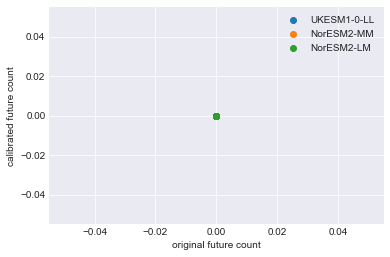

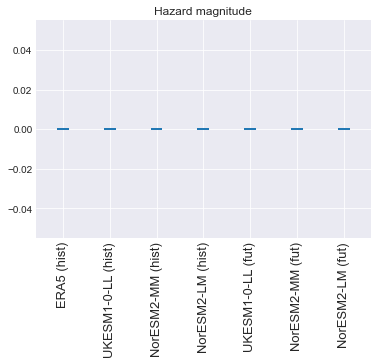

EVENT PROBABILITIES
  2.56% (UKESM1-0-LL)
  2.17% (NorESM2-MM)
  2.23% (NorESM2-LM)


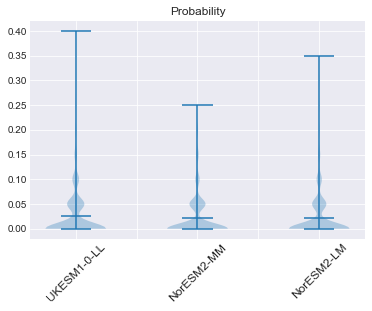


Ushuaia numdays_temp_lte_0 (04-01 - 09-15) >= 5
Best models:
  UKESM1-0-LL (RMSD=0.0)
  NorESM2-MM (RMSD=0.0)
  NorESM2-LM (RMSD=0.0)
Worst model is CMCC-CM2-SR5 (RMSD=10.44030650891055)


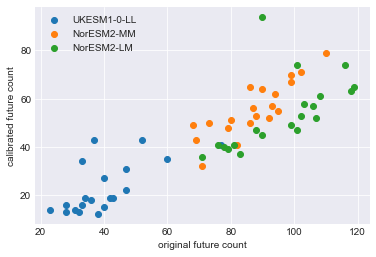

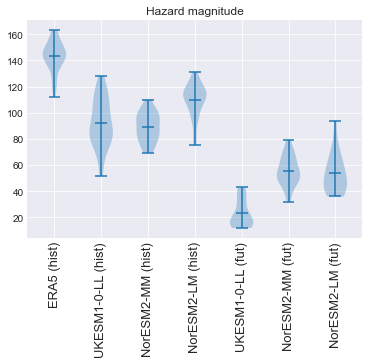

EVENT PROBABILITIES
  97.98% (UKESM1-0-LL)
  97.58% (NorESM2-MM)
  97.45% (NorESM2-LM)


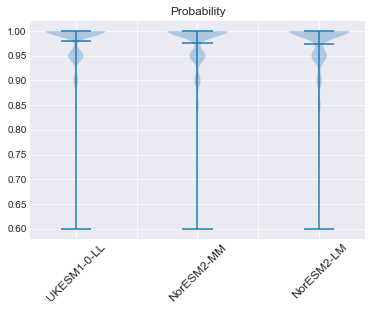


Manila numdays_temp_lte_0 (04-01 - 09-15) >= 5
Best models:
  UKESM1-0-LL (RMSD=0.0)
  NorESM2-MM (RMSD=0.0)
  NorESM2-LM (RMSD=0.0)
Worst model is ACCESS-CM2 (RMSD=0.0)


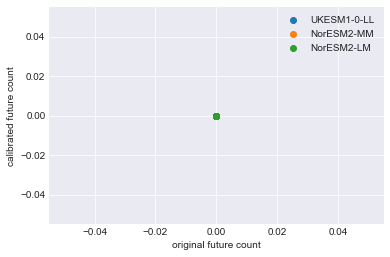

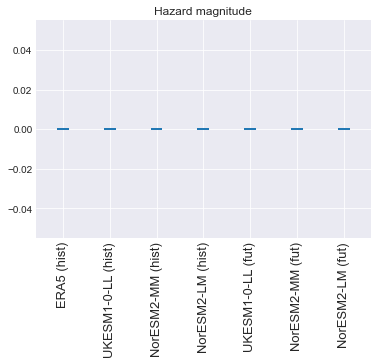

EVENT PROBABILITIES
  2.29% (UKESM1-0-LL)
  2.50% (NorESM2-MM)
  2.00% (NorESM2-LM)


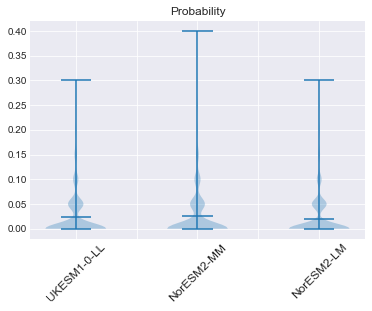


Marrakesh numdays_temp_lte_0 (04-01 - 09-15) >= 5
Best models:
  UKESM1-0-LL (RMSD=0.0)
  NorESM2-MM (RMSD=0.0)
  NorESM2-LM (RMSD=0.0)
Worst model is ACCESS-CM2 (RMSD=0.0)


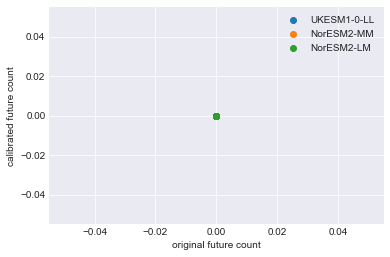

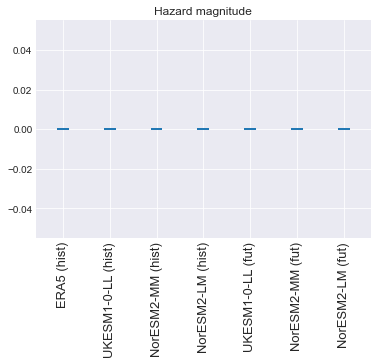

EVENT PROBABILITIES
  2.20% (UKESM1-0-LL)
  2.58% (NorESM2-MM)
  2.17% (NorESM2-LM)


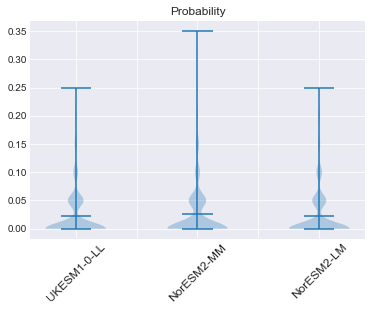


Detroit numdays_temp_lte_0 (04-01 - 09-15) >= 5
Best models:
  MIROC6 (RMSD=0.0)
  MIROC-ES2L (RMSD=0.0)
  HadGEM3-GC31-MM (RMSD=0.0)
Worst model is CMCC-CM2-SR5 (RMSD=8.717797887081348)


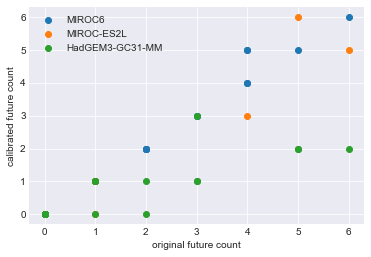

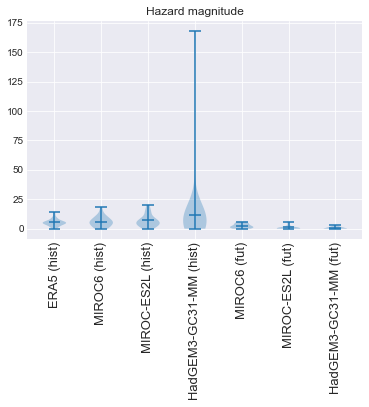

EVENT PROBABILITIES
  21.65% (MIROC6)
  12.16% (MIROC-ES2L)
  2.17% (HadGEM3-GC31-MM)


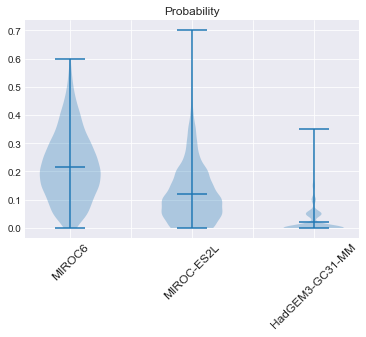


Stockholm numdays_temp_lte_0 (04-01 - 09-15) >= 5
Best models:
  NorESM2-MM (RMSD=0.0)
  MRI-ESM2-0 (RMSD=0.0)
  MIROC6 (RMSD=0.0)
Worst model is CMCC-CM2-SR5 (RMSD=11.874342087037917)


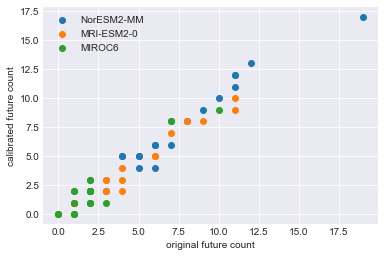

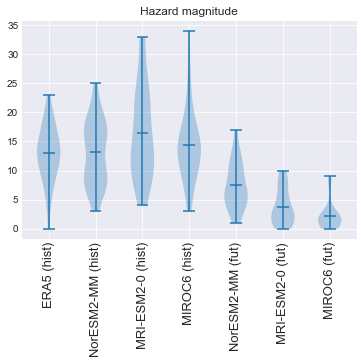

EVENT PROBABILITIES
  78.45% (NorESM2-MM)
  35.49% (MRI-ESM2-0)
  11.59% (MIROC6)


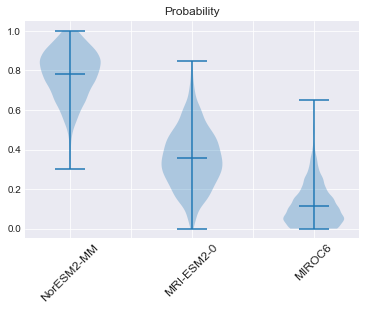


{'name': 'numruns_mintemp_gt_98th_runlength_5', 'description': 'number of runs of 5+ consecutive days with min temp >= local 98th percentile', 'excluded_models': [], 'greaterthan': True, 'variables': [{'nex_varname': 'tasmin', 'era5_varname': 'minimum_2m_air_temperature', 'nex_conversion': <function <lambda> at 0x000002B2B2F981F0>, 'era5_conversion': <function <lambda> at 0x000002B2B2F980D0>}], 'percentile_variables': [{'percentile': 98, 'usemax': True, 'nex_varname': 'tasmin', 'era5_varname': 'minimum_2m_air_temperature', 'nex_conversion': <function <lambda> at 0x000002B2B2F98CA0>, 'era5_conversion': <function <lambda> at 0x000002B2B2F98EE0>}], 'range': [1, 365, 1], 'nex_function': <function <lambda> at 0x000002B2B2F98820>, 'era5_function': <function <lambda> at 0x000002B2B2F98550>, 'prob_model': 'poisson'}
Kolkata numruns_mintemp_gt_98th_runlength_5 (04-01 - 09-15) >= 1
  Percentile value: 28.11
Best models:
  MRI-ESM2-0 (RMSD=0.0)
  INM-CM4-8 (RMSD=0.0)
  MPI-ESM1-2-LR (RMSD=1.0)
W

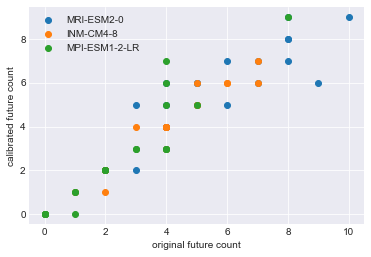

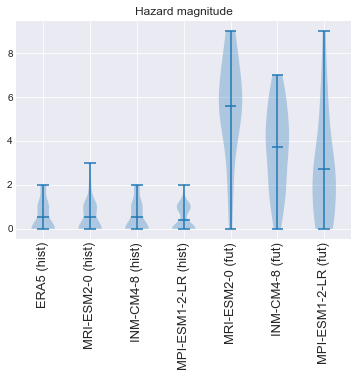

MEAN EVENT COUNT
  0.60 (MRI-ESM2-0)
  Probability that event count equals or exceeds 1: 33.60%
  0.58 (INM-CM4-8)
  Probability that event count equals or exceeds 1: 33.80%
  0.58 (MPI-ESM1-2-LR)
  Probability that event count equals or exceeds 1: 33.50%


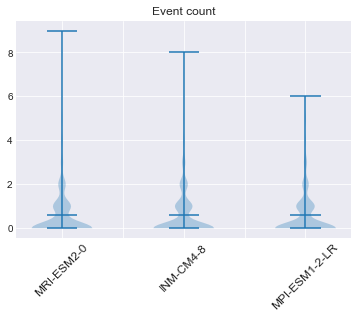


Ushuaia numruns_mintemp_gt_98th_runlength_5 (04-01 - 09-15) >= 1
  Percentile value: 2.47
Best models:
  NorESM2-MM (RMSD=6.164414002968976)
  ACCESS-CM2 (RMSD=6.4031242374328485)
  NorESM2-LM (RMSD=7.280109889280518)
Worst model is CMCC-CM2-SR5 (RMSD=13.038404810405298)


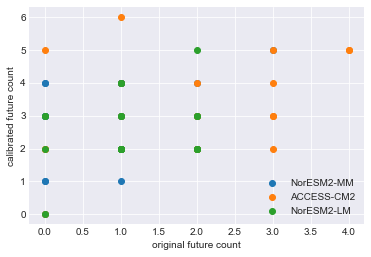

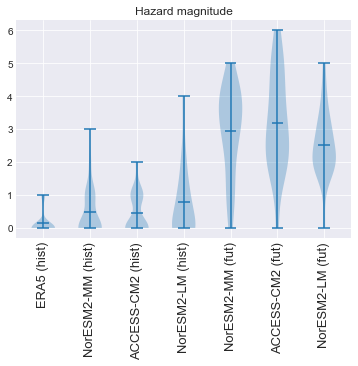

MEAN EVENT COUNT
  0.62 (NorESM2-MM)
  Probability that event count equals or exceeds 1: 34.30%
  0.60 (ACCESS-CM2)
  Probability that event count equals or exceeds 1: 34.70%
  0.63 (NorESM2-LM)
  Probability that event count equals or exceeds 1: 35.00%


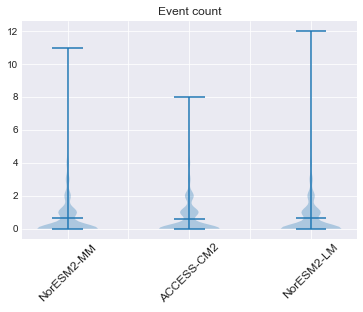


Manila numruns_mintemp_gt_98th_runlength_5 (04-01 - 09-15) >= 1
  Percentile value: 27.78
Best models:
  MIROC-ES2L (RMSD=1.0)
  KIOST-ESM (RMSD=4.0)
  CanESM5 (RMSD=4.0)
Worst model is CMCC-CM2-SR5 (RMSD=13.0)


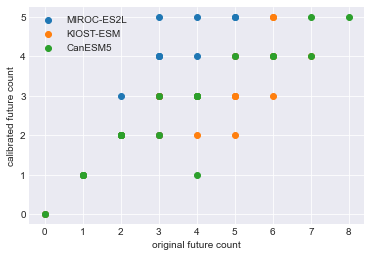

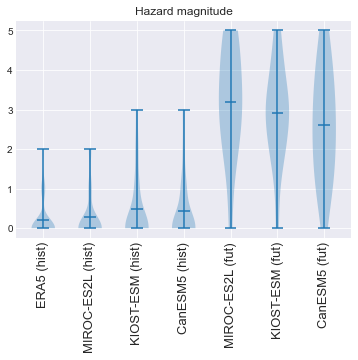

MEAN EVENT COUNT
  0.62 (MIROC-ES2L)
  Probability that event count equals or exceeds 1: 33.70%
  0.58 (KIOST-ESM)
  Probability that event count equals or exceeds 1: 33.50%
  0.59 (CanESM5)
  Probability that event count equals or exceeds 1: 34.20%


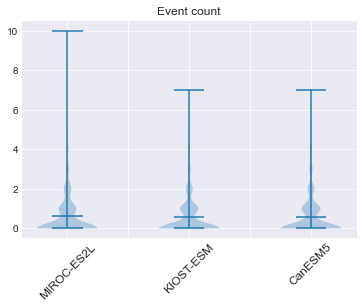


Marrakesh numruns_mintemp_gt_98th_runlength_5 (04-01 - 09-15) >= 1
  Percentile value: 23.65
Best models:
  MIROC-ES2L (RMSD=1.0)
  KIOST-ESM (RMSD=1.0)
  CanESM5 (RMSD=3.605551275463989)
Worst model is CMCC-CM2-SR5 (RMSD=13.152946437965905)


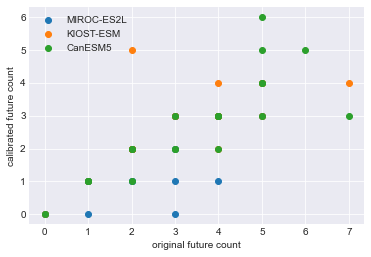

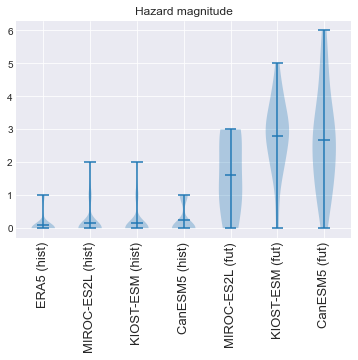

MEAN EVENT COUNT
  0.63 (MIROC-ES2L)
  Probability that event count equals or exceeds 1: 36.10%
  0.63 (KIOST-ESM)
  Probability that event count equals or exceeds 1: 34.50%
  0.58 (CanESM5)
  Probability that event count equals or exceeds 1: 33.60%


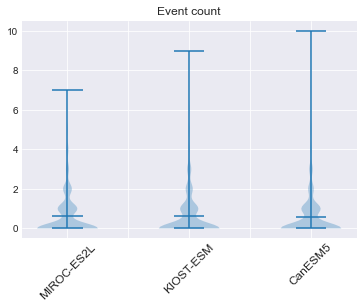


Detroit numruns_mintemp_gt_98th_runlength_5 (04-01 - 09-15) >= 1
  Percentile value: 22.76
Best models:
  MIROC6 (RMSD=0.0)
  MIROC-ES2L (RMSD=0.0)
  CanESM5 (RMSD=0.0)
Worst model is CMCC-CM2-SR5 (RMSD=14.317821063276353)


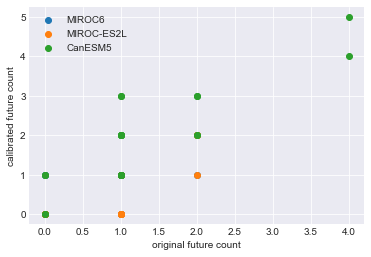

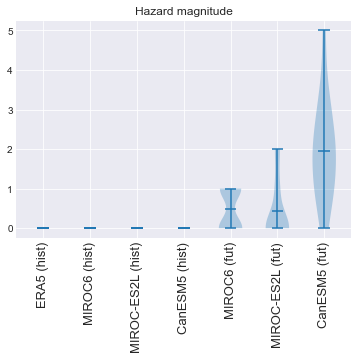

MEAN EVENT COUNT
  0.60 (MIROC6)
  Probability that event count equals or exceeds 1: 32.70%
  0.60 (MIROC-ES2L)
  Probability that event count equals or exceeds 1: 33.00%
  0.58 (CanESM5)
  Probability that event count equals or exceeds 1: 34.50%


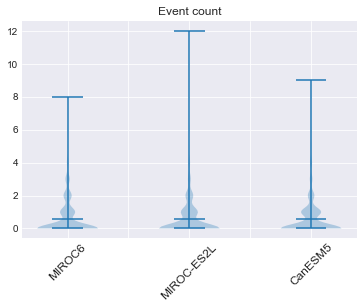


Stockholm numruns_mintemp_gt_98th_runlength_5 (04-01 - 09-15) >= 1
  Percentile value: 15.78
Best models:
  MPI-ESM1-2-LR (RMSD=0.0)
  MIROC-ES2L (RMSD=0.0)
  GFDL-ESM4 (RMSD=0.0)
Worst model is CMCC-CM2-SR5 (RMSD=13.0)


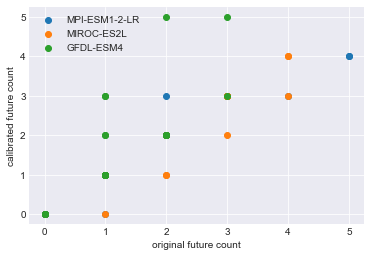

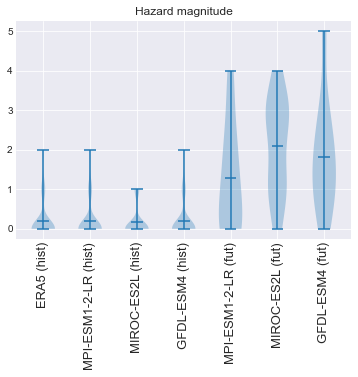

MEAN EVENT COUNT
  0.66 (MPI-ESM1-2-LR)
  Probability that event count equals or exceeds 1: 33.90%
  0.58 (MIROC-ES2L)
  Probability that event count equals or exceeds 1: 33.60%
  0.64 (GFDL-ESM4)
  Probability that event count equals or exceeds 1: 36.10%


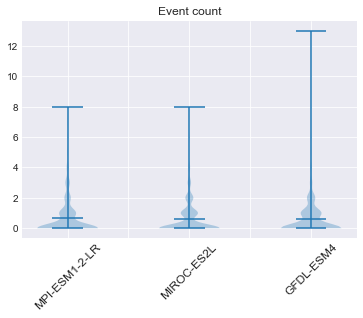


{'name': 'maxrunduration_precip_eq_0', 'description': 'duration in days of longest drought', 'excluded_models': [], 'greaterthan': True, 'variables': [{'nex_varname': 'pr', 'era5_varname': 'total_precipitation', 'nex_conversion': <function <lambda> at 0x000002B2B2F98F70>, 'era5_conversion': <function <lambda> at 0x000002B2B2F98E50>}], 'percentile_variables': [], 'range': [1, 365, 1], 'nex_function': <function <lambda> at 0x000002B2B3066040>, 'era5_function': <function <lambda> at 0x000002B2B30661F0>, 'prob_model': 'binomial'}
Kolkata maxrunduration_precip_eq_0 (04-01 - 09-15) >= 15
Best models:
  MPI-ESM1-2-LR (RMSD=0.0)
  FGOALS-g3 (RMSD=0.0)
  CanESM5 (RMSD=0.0)
Worst model is GFDL-CM4 (RMSD=9.848857801796104)


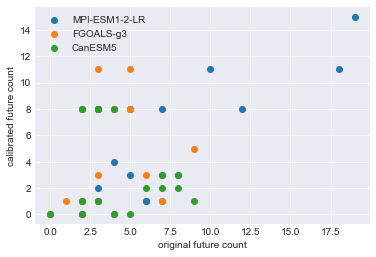

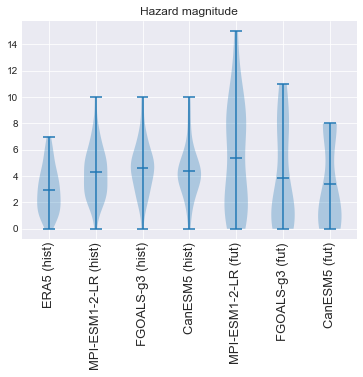

EVENT PROBABILITIES
  6.75% (MPI-ESM1-2-LR)
  2.32% (FGOALS-g3)
  2.22% (CanESM5)


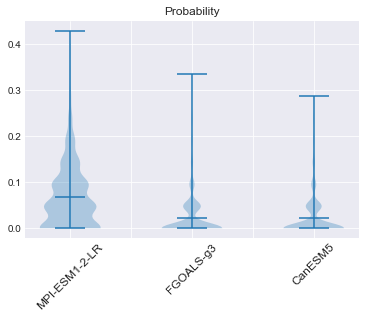


Ushuaia maxrunduration_precip_eq_0 (04-01 - 09-15) >= 15
Best models:
  UKESM1-0-LL (RMSD=0.0)
  NorESM2-LM (RMSD=0.0)
  MRI-ESM2-0 (RMSD=0.0)
Worst model is EC-Earth3 (RMSD=6.0)


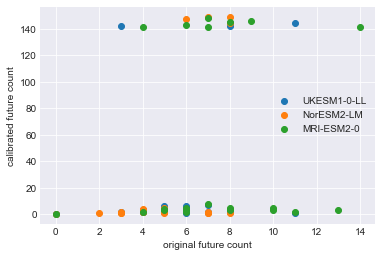

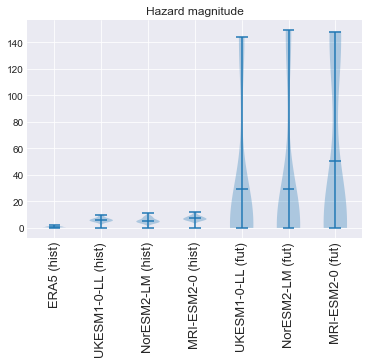

EVENT PROBABILITIES
  20.81% (UKESM1-0-LL)
  20.68% (NorESM2-LM)
  34.10% (MRI-ESM2-0)


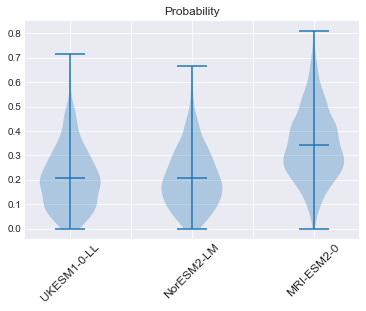


Manila maxrunduration_precip_eq_0 (04-01 - 09-15) >= 15
Best models:
  MIROC-ES2L (RMSD=0.0)
  KIOST-ESM (RMSD=0.0)
  KACE-1-0-G (RMSD=0.0)
Worst model is CMCC-ESM2 (RMSD=7.211102550927978)


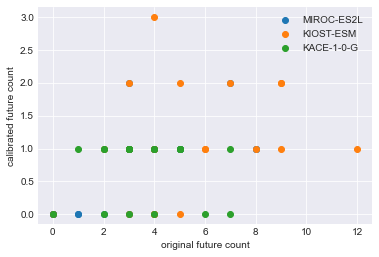

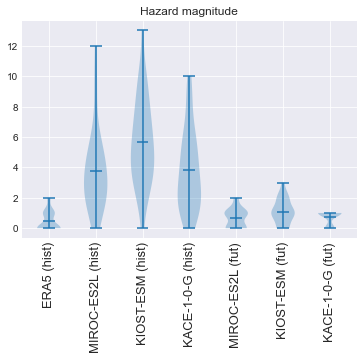

EVENT PROBABILITIES
  2.38% (MIROC-ES2L)
  2.10% (KIOST-ESM)
  2.16% (KACE-1-0-G)


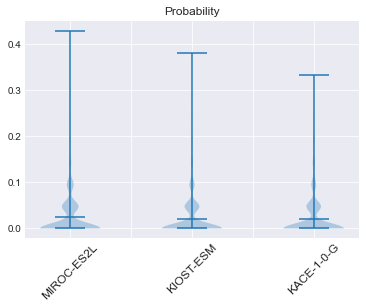


Marrakesh maxrunduration_precip_eq_0 (04-01 - 09-15) >= 15
Best models:
  UKESM1-0-LL (RMSD=13.92838827718412)
  NorESM2-MM (RMSD=13.92838827718412)
  NorESM2-LM (RMSD=13.92838827718412)
Worst model is ACCESS-CM2 (RMSD=13.92838827718412)


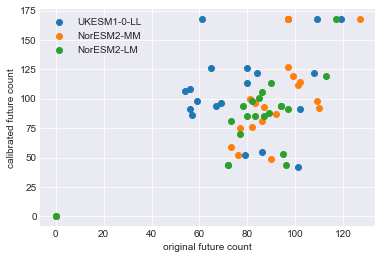

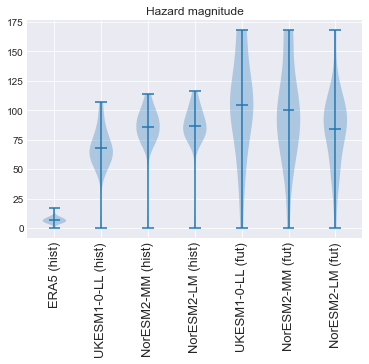

EVENT PROBABILITIES
  93.40% (UKESM1-0-LL)
  93.21% (NorESM2-MM)
  92.90% (NorESM2-LM)


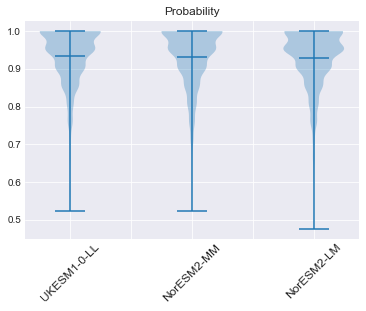


Detroit maxrunduration_precip_eq_0 (04-01 - 09-15) >= 15
Best models:
  UKESM1-0-LL (RMSD=0.0)
  MRI-ESM2-0 (RMSD=0.0)
  MPI-ESM1-2-HR (RMSD=0.0)
Worst model is EC-Earth3-Veg-LR (RMSD=3.0)


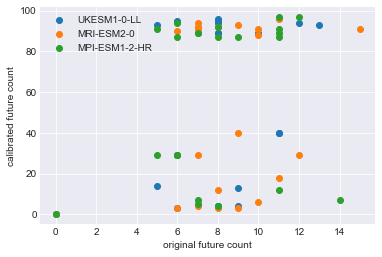

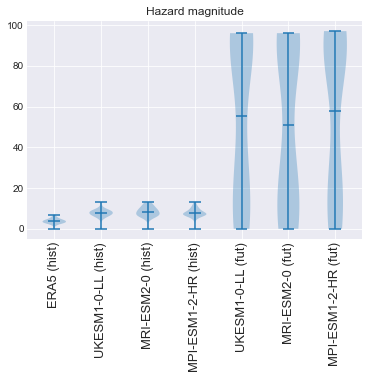

EVENT PROBABILITIES
  65.89% (UKESM1-0-LL)
  65.68% (MRI-ESM2-0)
  70.03% (MPI-ESM1-2-HR)


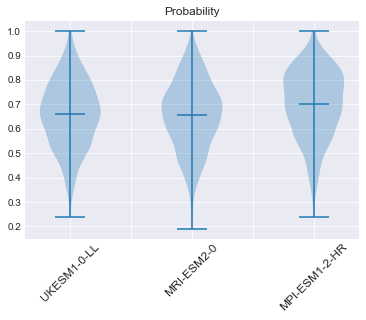


Stockholm maxrunduration_precip_eq_0 (04-01 - 09-15) >= 15
Best models:
  FGOALS-g3 (RMSD=0.0)
  INM-CM4-8 (RMSD=1.0)
  CanESM5 (RMSD=1.0)
Worst model is GFDL-ESM4 (RMSD=8.54400374531753)


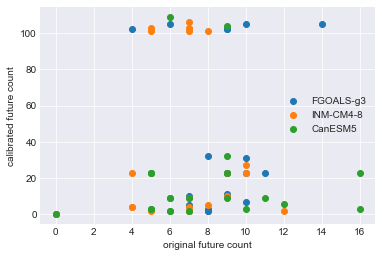

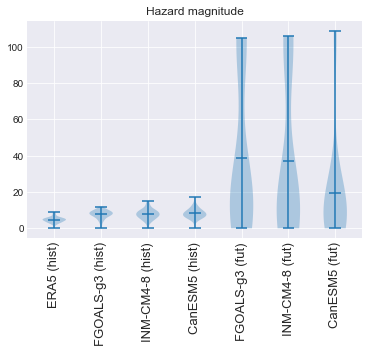

EVENT PROBABILITIES
  56.67% (FGOALS-g3)
  52.86% (INM-CM4-8)
  33.55% (CanESM5)


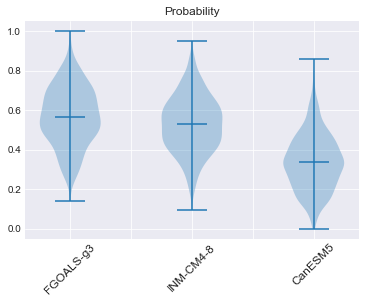


{'name': 'numdays_wetbulbtemperature_gte_30', 'description': 'number of days with max wet bulb temperature >= 30', 'excluded_models': ('BCC-CSM2-MR', 'NESM3', 'KIOST-ESM'), 'greaterthan': True, 'variables': [{'nex_varname': 'tasmax', 'era5_varname': 'maximum_2m_air_temperature', 'nex_conversion': <function <lambda> at 0x000002B2B30663A0>, 'era5_conversion': <function <lambda> at 0x000002B2B3066430>}, {'nex_varname': 'hurs', 'era5_varname': None, 'nex_conversion': <function <lambda> at 0x000002B2B3066550>, 'era5_conversion': None}, {'nex_varname': None, 'era5_varname': 'dewpoint_2m_temperature', 'nex_conversion': None, 'era5_conversion': <function <lambda> at 0x000002B2B30664C0>}], 'percentile_variables': [], 'range': [1, 365, 1], 'nex_function': <function <lambda> at 0x000002B2B30665E0>, 'era5_function': <function <lambda> at 0x000002B2B3066670>, 'prob_model': 'binomial'}
Kolkata numdays_wetbulbtemperature_gte_30 (04-01 - 09-15) >= 20
Best models:
  UKESM1-0-LL (RMSD=12.24744871391589

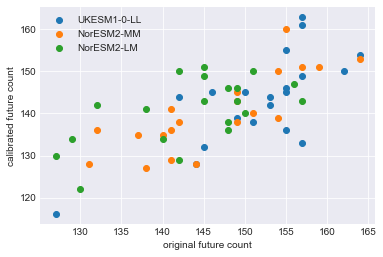

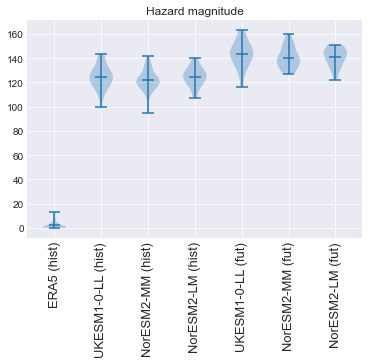

EVENT PROBABILITIES
  97.54% (UKESM1-0-LL)
  97.52% (NorESM2-MM)
  97.74% (NorESM2-LM)


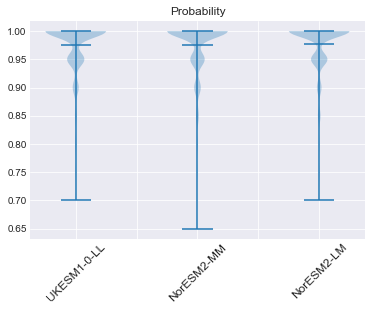


Ushuaia numdays_wetbulbtemperature_gte_30 (04-01 - 09-15) >= 20
Best models:
  UKESM1-0-LL (RMSD=0.0)
  NorESM2-MM (RMSD=0.0)
  NorESM2-LM (RMSD=0.0)
Worst model is ACCESS-CM2 (RMSD=0.0)


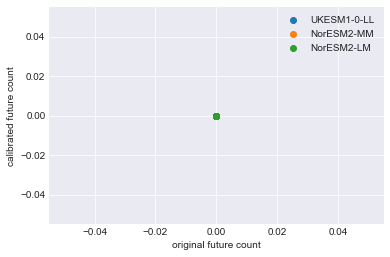

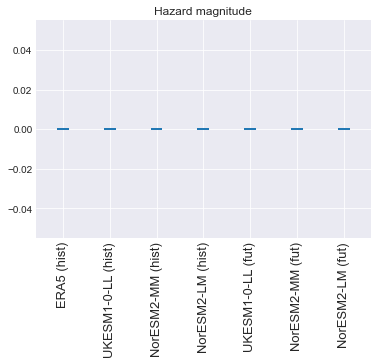

EVENT PROBABILITIES
  2.37% (UKESM1-0-LL)
  2.56% (NorESM2-MM)
  2.41% (NorESM2-LM)


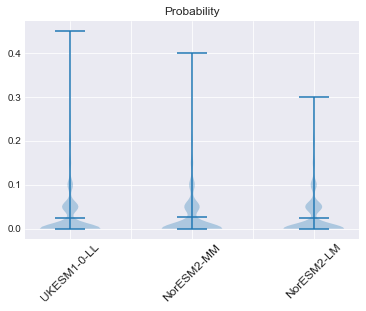


Manila numdays_wetbulbtemperature_gte_30 (04-01 - 09-15) >= 20
Best models:
  UKESM1-0-LL (RMSD=0.0)
  NorESM2-MM (RMSD=0.0)
  NorESM2-LM (RMSD=0.0)
Worst model is ACCESS-CM2 (RMSD=0.0)


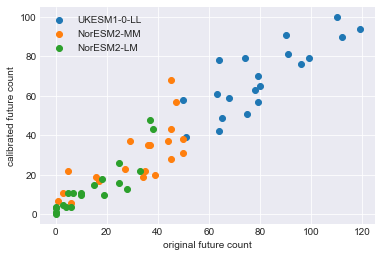

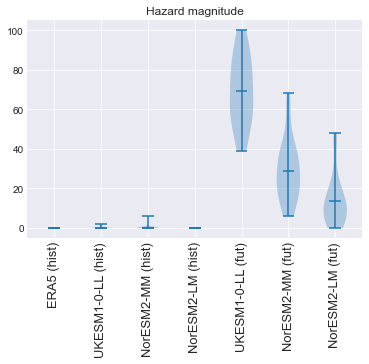

EVENT PROBABILITIES
  97.53% (UKESM1-0-LL)
  68.56% (NorESM2-MM)
  21.04% (NorESM2-LM)


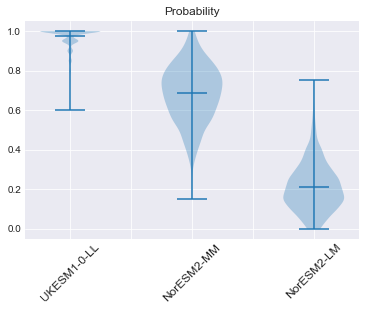


Marrakesh numdays_wetbulbtemperature_gte_30 (04-01 - 09-15) >= 20
Best models:
  UKESM1-0-LL (RMSD=0.0)
  NorESM2-MM (RMSD=0.0)
  NorESM2-LM (RMSD=0.0)
Worst model is ACCESS-CM2 (RMSD=0.0)


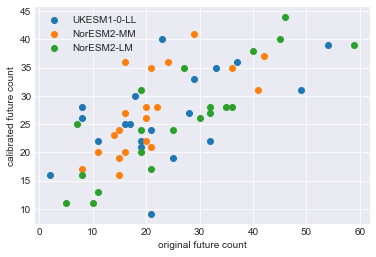

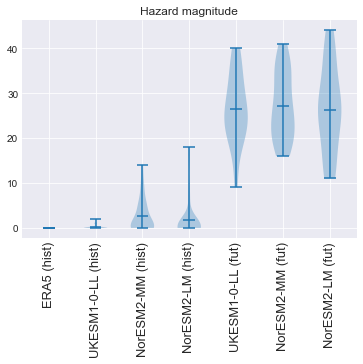

EVENT PROBABILITIES
  83.70% (UKESM1-0-LL)
  83.71% (NorESM2-MM)
  74.55% (NorESM2-LM)


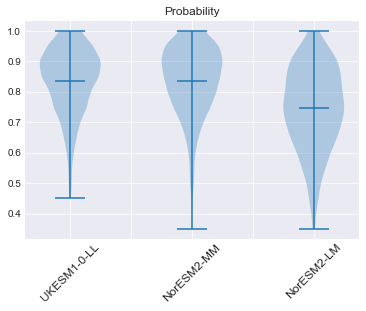


Detroit numdays_wetbulbtemperature_gte_30 (04-01 - 09-15) >= 20
Best models:
  UKESM1-0-LL (RMSD=0.0)
  NorESM2-MM (RMSD=0.0)
  NorESM2-LM (RMSD=0.0)
Worst model is ACCESS-CM2 (RMSD=0.0)


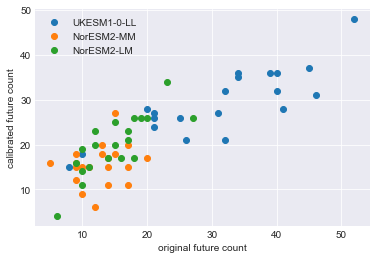

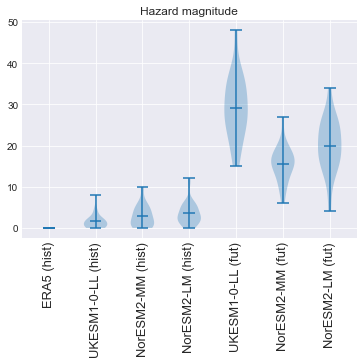

EVENT PROBABILITIES
  88.88% (UKESM1-0-LL)
  16.79% (NorESM2-MM)
  54.17% (NorESM2-LM)


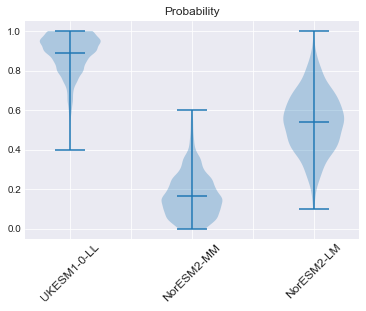


Stockholm numdays_wetbulbtemperature_gte_30 (04-01 - 09-15) >= 20
Best models:
  UKESM1-0-LL (RMSD=0.0)
  NorESM2-MM (RMSD=0.0)
  NorESM2-LM (RMSD=0.0)
Worst model is ACCESS-CM2 (RMSD=0.0)


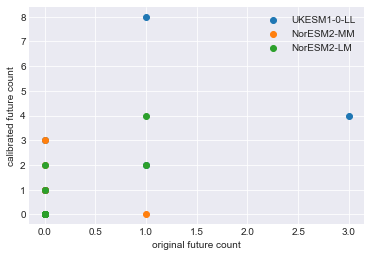

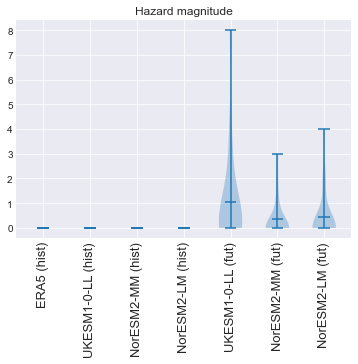

EVENT PROBABILITIES
  2.19% (UKESM1-0-LL)
  2.45% (NorESM2-MM)
  2.28% (NorESM2-LM)


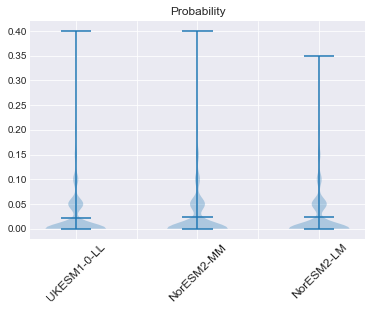


CPU times: total: 10min 4s
Wall time: 4h 42min 54s


In [233]:
%%time

allresults = {}
allcounts = {}
modvars = {}

for indicator in [indicators[i] for i in indicators]:
    print(indicator)
    allresults[indicator['name']] = {}
    allcounts[indicator['name']] = {}
    for location in LOCATIONS:
        allcounts[indicator['name']][location['name']] = {}
        latlon = location['latlon']
        test_threshold = TEST_THRESHOLDS[indicator['name']]
        #test_window = [nh_window, sh_window][int(latlon[0] < 0)]
        test_window = nh_window
        print(location['name'], indicator['name'], '({0} - {1})'.format(test_window[0], test_window[1]), ['<=', '>='][int(indicator['greaterthan'])], test_threshold)

        percentile_values = []
        for percentile_variable in indicator['percentile_variables']:
            percentile_values.append(get_percentile_value(percentile_variable, latlon[0], latlon[1], test_window, HIST_START, HIST_END))
            
        if percentile_values:
            print('  Percentile value{0}: {1}'.format(['', 's'][int(len(percentile_values) > 1)], ', '.join(['{0:.2f}'.format(i) for i in percentile_values])))
        #print('Getting historical event counts')
        obs_counts, obs_vars = get_mags(latlon[0], latlon[1], test_window, HIST_START, HIST_END, 'ERA5', indicator, percentile_values, None)
        allcounts[indicator['name']][location['name']]['hist_obs'] = obs_counts
        mod_counts = {}
        rmsd_to_models = {}
        models_to_rmsd = {}
        
        rmsds = []
        for model in MODELS:
            if not model in indicator['excluded_models']:
                mags, modvars[model] = get_mags(latlon[0], latlon[1], test_window, HIST_START, HIST_END, model, indicator, percentile_values, None)
                if mags is not None:
                    mod_counts[model] = np.array(mags)
                    if indicator['greaterthan']:
                        rmsd = get_rmsd(obs_counts >= test_threshold, mod_counts[model] >= test_threshold)
                    else:
                        rmsd = get_rmsd(obs_counts <= test_threshold, mod_counts[model] <= test_threshold)
                    rmsds.append((model, rmsd))
                    
        allcounts[indicator['name']][location['name']]['hist_mod'] = mod_counts
        rmsds.sort(key = lambda x: x[1])
        best_models = rmsds[:NUM_BEST_MODELS]
        print('Best models:')
        for model in best_models:
            print('  {0} (RMSD={1})'.format(model[0], model[1]))
        print('Worst model is {0} (RMSD={1})'.format(rmsds[-1][0], rmsds[-1][1]))
        
        all_posteriorFM_draws = {}
        displaynums = {}
        event_distribs = {}
        future_modcounts = {}
        uncalibrated_future_modcounts = {}
        
        best_models = [i[0] for i in best_models]
        
        for model in best_models:
            
            calibration_functions = [calibration_function(obs_vars[i], modvars[model][i]) for i in range(len(obs_vars))]
            
            #print('Processing {0}'.format(model))
            future_modcounts[model], uncalibrated_future_modcounts[model] = get_mags(latlon[0], latlon[1], test_window, FUTURE_START, FUTURE_END, model, indicator, percentile_values, calibration_functions)
            
            if indicator['prob_model'] == 'poisson':
                posteriorH_draws = get_gamma(obs_counts.mean(), 10000)
                posteriorHM_draws = get_gamma(mod_counts[model].mean(), 10000)
                posteriorFM_draws = get_gamma(fmod.mean(), 10000)
            else:
                if indicator['greaterthan']:
                    fmod = future_modcounts[model] >= test_threshold
                    hobs = obs_counts >= test_threshold
                    hmod = mod_counts[model] >= test_threshold
                else:
                    fmod = future_modcounts[model] <= test_threshold
                    hobs = obs_counts <= test_threshold
                    hmod = mod_counts[model] <= test_threshold

                posteriorH_draws = get_beta(hobs.sum(), hobs.size, 10000)
                posteriorHM_draws = get_beta(hmod.sum(), hmod.size, 10000)
                posteriorFM_draws = get_beta(fmod.sum(), fmod.size, 10000)
            
            plt.scatter(uncalibrated_future_modcounts[model], future_modcounts[model], label=model)
            plt.xlabel('original future count')
            plt.ylabel('calibrated future count')
            plt.legend()
            all_posteriorFM_draws[model] = posteriorFM_draws
        
        allcounts[indicator['name']][location['name']]['future_mod'] = future_modcounts

        fig, ax = plt.subplots()
        ax.violinplot([obs_counts] + [mod_counts[i] for i in best_models] + [future_modcounts[i] for i in best_models], showmeans=True)
        ax.set_xticklabels([None, 'ERA5 (hist)'] + ['{0} (hist)'.format(best_models[i]) for i in range(3)] + ['{0} (fut)'.format(best_models[i]) for i in range(3)], rotation=90, fontsize=13)
        ax.set_title('Hazard magnitude')
        plt.show()
        
        for model in best_models:
            uniform_draws = np.random.randint(low=0, high=10000, size=1000)
            if indicator['prob_model'] == 'poisson':
                cFM_draws = np.random.poisson(lam=all_posteriorFM_draws[model][uniform_draws], size=1000)# / fmod.size
                displaynums[model] = cFM_draws.mean()
                event_distribs[model] = cFM_draws
            else:
                cFM_draws = np.random.binomial(n=fmod.size, p=all_posteriorFM_draws[model][uniform_draws], size=1000) / fmod.size
                displaynums[model] = cFM_draws.mean()
                event_distribs[model] = cFM_draws
        if indicator['prob_model'] == 'poisson':
            print('MEAN EVENT COUNT')
            report_probs = []
            for model in best_models:
                print('  {0:.2f} ({1})'.format(displaynums[model], model))
                prob = np.sum(event_distribs[model] >= 1) / event_distribs[model].size
                report_probs.append((model, prob))
                print('  Probability that event count equals or exceeds {0}: {1:.2f}%'.format(test_threshold, prob * 100))
        else:
            print('EVENT PROBABILITIES')
            for model in best_models:
                prob = displaynums[model]
                print('  {0:.2f}% ({1})'.format(prob * 100, model))
            report_probs = [(i, displaynums[i]) for i in best_models]
        allresults[indicator['name']][location['name']] = report_probs
        
        fig2, ax2 = plt.subplots()
        ax2.violinplot(event_distribs.values(), showmeans=True)
        ax2.set_xticklabels([None, '{0}'.format(best_models[0]), None, '{0}'.format(best_models[1]), None, '{0}'.format(best_models[2])], rotation=45, fontsize=12)
        ax2.set_title(['Event count', 'Probability'][int(indicator['prob_model'] == 'binomial')])
        #if indicator['prob_model'] == 'poisson':
        #    ax2.plot([1, 3], [test_threshold, test_threshold], marker='')
        plt.show()
        
        print('=======================================================')
        print()

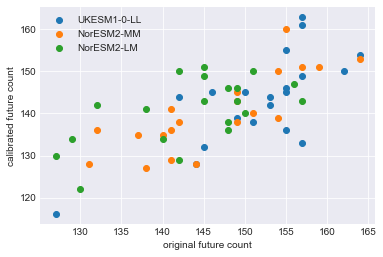

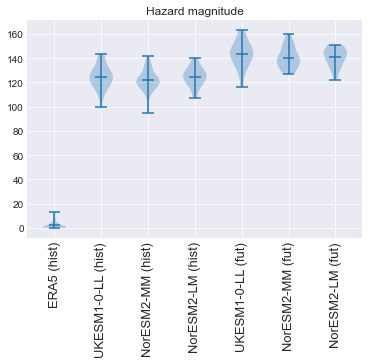

EVENT PROBABILITIES
  97.68% (UKESM1-0-LL)
  97.65% (NorESM2-MM)
  97.50% (NorESM2-LM)


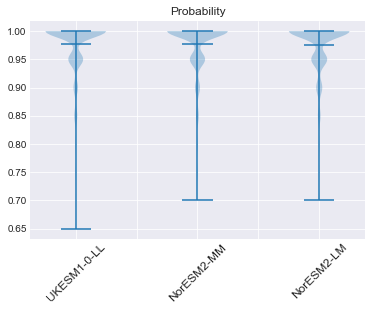

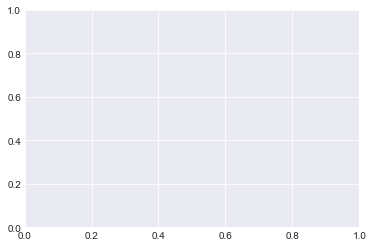

In [232]:
for model in best_models:

    calibration_functions = [calibration_function(obs_vars[i], modvars[model][i]) for i in range(len(obs_vars))]

    #print('Processing {0}'.format(model))
    future_modcounts[model], uncalibrated_future_modcounts[model] = get_mags(latlon[0], latlon[1], test_window, FUTURE_START, FUTURE_END, model, indicator, percentile_values, calibration_functions)

    if indicator['prob_model'] == 'poisson':
        posteriorH_draws = get_gamma(obs_counts.mean(), 10000)
        posteriorHM_draws = get_gamma(mod_counts[model].mean(), 10000)
        posteriorFM_draws = get_gamma(fmod.mean(), 10000)
    else:
        if indicator['greaterthan']:
            fmod = future_modcounts[model] >= test_threshold
            hobs = obs_counts >= test_threshold
            hmod = mod_counts[model] >= test_threshold
        else:
            fmod = future_modcounts[model] <= test_threshold
            hobs = obs_counts <= test_threshold
            hmod = mod_counts[model] <= test_threshold

        posteriorH_draws = get_beta(hobs.sum(), hobs.size, 10000)
        posteriorHM_draws = get_beta(hmod.sum(), hmod.size, 10000)
        posteriorFM_draws = get_beta(fmod.sum(), fmod.size, 10000)

    plt.scatter(uncalibrated_future_modcounts[model], future_modcounts[model], label=model)
    plt.xlabel('original future count')
    plt.ylabel('calibrated future count')
    plt.legend()
    all_posteriorFM_draws[model] = posteriorFM_draws

allcounts[indicator['name']][location['name']]['future_mod'] = future_modcounts

fig, ax = plt.subplots()
ax.violinplot([obs_counts] + [mod_counts[i] for i in best_models] + [future_modcounts[i] for i in best_models], showmeans=True)
ax.set_xticklabels([None, 'ERA5 (hist)'] + ['{0} (hist)'.format(best_models[i]) for i in range(3)] + ['{0} (fut)'.format(best_models[i]) for i in range(3)], rotation=90, fontsize=13)
ax.set_title('Hazard magnitude')
plt.show()

for model in best_models:
    uniform_draws = np.random.randint(low=0, high=10000, size=1000)
    if indicator['prob_model'] == 'poisson':
        cFM_draws = np.random.poisson(lam=all_posteriorFM_draws[model][uniform_draws], size=1000)# / fmod.size
        displaynums[model] = cFM_draws.mean()
        event_distribs[model] = cFM_draws
    else:
        cFM_draws = np.random.binomial(n=fmod.size, p=all_posteriorFM_draws[model][uniform_draws], size=1000) / fmod.size
        displaynums[model] = cFM_draws.mean()
        event_distribs[model] = cFM_draws
if indicator['prob_model'] == 'poisson':
    print('MEAN EVENT COUNT')
    report_probs = []
    for model in best_models:
        print('  {0:.2f} ({1})'.format(displaynums[model], model))
        prob = np.sum(event_distribs[model] >= 1) / event_distribs[model].size
        report_probs.append((model, prob))
        print('  Probability that event count equals or exceeds {0}: {1:.2f}%'.format(test_threshold, prob * 100))
else:
    print('EVENT PROBABILITIES')
    for model in best_models:
        prob = displaynums[model]
        print('  {0:.2f}% ({1})'.format(prob * 100, model))
    report_probs = [(i, displaynums[i]) for i in best_models]
allresults[indicator['name']][location['name']] = report_probs

fig2, ax2 = plt.subplots()
ax2.violinplot(event_distribs.values(), showmeans=True)
ax2.set_xticklabels([None, '{0}'.format(best_models[0]), None, '{0}'.format(best_models[1]), None, '{0}'.format(best_models[2])], rotation=45, fontsize=12)
ax2.set_title(['Event count', 'Probability'][int(indicator['prob_model'] == 'binomial')])
#if indicator['prob_model'] == 'poisson':
#    ax2.plot([1, 3], [test_threshold, test_threshold], marker='')
plt.show()
fig2, ax2 = plt.subplots()

In [230]:
r

(array([138, 145, 163, 144, 116, 161, 139, 142, 133, 128, 136, 132, 146,
        145, 149, 145, 150, 154, 155, 144]),
 array([151, 146, 157, 142, 127, 157, 149, 153, 157, 144, 155, 145, 155,
        150, 157, 155, 162, 164, 155, 153]))

In [208]:
hist_obs, hist_mod = obs_vars[1], modvars[model][1]
new_indices = []
source = np.sort(hist_obs.flatten())
target= np.sort(hist_mod.flatten())
#source[-1] = target[-1]  # when target[i] greater than all source values, return max index
for target_idx, target_value in enumerate(target):
    source_value = source[target_idx]
    if source_value > target[-1]:
        new_indices.append(target.size - 1)
    else:
        new_indices.append(np.argmax(target >= source_value))
np.array(new_indices) / source.size

IndexError: index 35 is out of bounds for axis 0 with size 35

In [215]:
source

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [188]:
get_mags(LOCATIONS[1]['latlon'][0], LOCATIONS[1]['latlon'][1], test_window, FUTURE_START, FUTURE_END, model, indicator, percentile_values, calibration_functions)

[array([[5.209008789062523, 5.209008789062523, 5.209008789062523, ...,
        -2.1047424316406023, -0.9521240234374773, -0.7595275878906023],
       [6.859429931640648, 6.859429931640648, 6.859429931640648, ...,
        -2.3633178710937273, -0.7229370117187273, 0.49306640625002274],
       [1.6111999511718977, 1.6111999511718977, 1.6111999511718977, ...,
        -2.6005615234374773, 1.9623962402343977, -1.0006469726562273],
       ...,
       [1.2838073730468977, 1.2838073730468977, 1.2838073730468977, ...,
        -0.24921264648435226, -0.15936889648435226, -1.6962036132812273],
       [4.528894042968773, 4.528894042968773, 4.528894042968773, ...,
        1.6252075195312727, 0.8732849121093977, 4.840539550781273],
       [4.054406738281273, 4.054406738281273, 4.054406738281273, ...,
        0.19335327148439774, -1.8487609863281023, 3.2825561523437727]],
      dtype=object)] [array([[5.209008789062523, 4.891961669921898, 7.313470458984398, ...,
        3.0701538085937727, 4.1015563964

(array([39, 52, 49, 74, 47, 74, 41, 47, 57, 61, 94, 58, 63, 65, 37, 45, 53,
        41, 36, 40]),
 array([ 79, 107,  99, 116, 101, 101,  81,  88, 106, 108,  90, 103, 118,
        119,  83,  90, 102,  76,  71,  78]))

In [186]:
lat, lon, window, start_year, end_year, model, indicator, percentile_values, calibration_functions = LOCATIONS[1]['latlon'][0], LOCATIONS[1]['latlon'][1], test_window, FUTURE_START, FUTURE_END, model, indicator, percentile_values, calibration_functions
scenario = 'ssp585'
# Returns array of event counts, one for each year
    
    #print('  {0} {1} - {2}'.format(model, start_year, end_year))
    
gee_geom = ee.Geometry.Point((lon, lat))

allvars = []
uncalibrated_allvars = []
for idx, variable in enumerate(indicator['variables']):
    if model == 'ERA5':
        varname = variable['era5_varname']
        is_forecast = varname == "precipitation_amount_1hour_Accumulation"
        dataset = ee.ImageCollection("ECMWF/ERA5/DAILY")
        conversion_fxn = variable['era5_conversion']
        indicator_fxn = indicator['era5_function']
    else:
        varname = variable['nex_varname']
        dataset = ee.ImageCollection('NASA/GDDP-CMIP6').filter(ee.Filter.eq('model', model))
        conversion_fxn = variable['nex_conversion']
        indicator_fxn = indicator['nex_function']
    allyears = []
    uncalibrated_allyears = []
    if varname is not None:
        for year in range(start_year, end_year):
            window_start = datetime.datetime.strptime('{0}-{1}'.format(year, window[0]), '%Y-%m-%d')
            if False and calendar.isleap(year) and d2j(window_start.strftime('%Y-%m-%d')) > 28:  # So arrays have same length for leap years
                window_start = window_start + datetime.timedelta(days=1)
            window_end_plusone = datetime.datetime.strptime('{0}-{1}'.format(year, window[1]), '%Y-%m-%d') + datetime.timedelta(days=1) 
            data_vars = dataset.select(varname).filter(ee.Filter.date(window_start.strftime('%Y-01-01'), window_end_plusone.strftime('%Y-12-31')))
            if model != 'ERA5':
                data_vars = data_vars.filter(ee.Filter.eq('scenario', [scenario, 'historical'][int(year < 2015)]))
            yeardata = pd.DataFrame(data_vars.getRegion(gee_geom, 2500, 'epsg:4326').getInfo())[4][1:]
            yeardata = np.array(yeardata[d2j(window_start.strftime('%Y-%m-%d'))+0: d2j(window_end_plusone.strftime('%Y-%m-%d'))+0])
            if yeardata[0] is None:
                print(None)
            yeardata = conversion_fxn(yeardata)
            if calibration_functions is not None:
                uncalibrated_allyears.append(yeardata)
                cf = calibration_functions[idx][[round((i / yeardata.size) * calibration_functions[idx].size) for i in range(yeardata.size)]]
                yeardata = yeardata[np.floor(cf * yeardata.size).astype(np.int32)]
            allyears.append(yeardata)
    else:
        allyears = np.zeros(end_year - start_year)
    if calibration_functions is not None:
        uncalibrated_allvars.append(np.vstack(uncalibrated_allyears))
    allvars.append(np.vstack(allyears))

if percentile_values:
    if calibration_functions is not None:
        uncalibrated_allvars += percentile_values
    allvars += percentile_values
if calibration_functions is None:
    if percentile_values:
        print( indicator_fxn(allvars), allvars[:-1])
    else:
        print(indicator_fxn(allvars), allvars)
else:
    print(allvars, uncalibrated_allvars)
indicator_fxn(allvars), indicator_fxn(uncalibrated_allvars)

[array([[5.209008789062523, 5.209008789062523, 5.209008789062523, ...,
        -2.1047424316406023, -0.9521240234374773, -0.7595275878906023],
       [6.859429931640648, 6.859429931640648, 6.859429931640648, ...,
        -2.3633178710937273, -0.7229370117187273, 0.49306640625002274],
       [1.6111999511718977, 1.6111999511718977, 1.6111999511718977, ...,
        -2.6005615234374773, 1.9623962402343977, -1.0006469726562273],
       ...,
       [1.2838073730468977, 1.2838073730468977, 1.2838073730468977, ...,
        -0.24921264648435226, -0.15936889648435226, -1.6962036132812273],
       [4.528894042968773, 4.528894042968773, 4.528894042968773, ...,
        1.6252075195312727, 0.8732849121093977, 4.840539550781273],
       [4.054406738281273, 4.054406738281273, 4.054406738281273, ...,
        0.19335327148439774, -1.8487609863281023, 3.2825561523437727]],
      dtype=object)] [array([[5.209008789062523, 4.891961669921898, 7.313470458984398, ...,
        3.0701538085937727, 4.1015563964

(array([39, 52, 49, 74, 47, 74, 41, 47, 57, 61, 94, 58, 63, 65, 37, 45, 53,
        41, 36, 40]),
 array([ 79, 107,  99, 116, 101, 101,  81,  88, 106, 108,  90, 103, 118,
        119,  83,  90, 102,  76,  71,  78]))

In [174]:
[i / calibration_functions[idx].size for i in range(yeardata.size)]

[0.0,
 0.00017006802721088434,
 0.0003401360544217687,
 0.0005102040816326531,
 0.0006802721088435374,
 0.0008503401360544217,
 0.0010204081632653062,
 0.0011904761904761906,
 0.0013605442176870747,
 0.001530612244897959,
 0.0017006802721088435,
 0.0018707482993197278,
 0.0020408163265306124,
 0.002210884353741497,
 0.002380952380952381,
 0.002551020408163265,
 0.0027210884353741495,
 0.002891156462585034,
 0.003061224489795918,
 0.0032312925170068026,
 0.003401360544217687,
 0.0035714285714285713,
 0.0037414965986394557,
 0.0039115646258503405,
 0.004081632653061225,
 0.004251700680272109,
 0.004421768707482994,
 0.004591836734693878,
 0.004761904761904762,
 0.004931972789115646,
 0.00510204081632653,
 0.005272108843537415,
 0.005442176870748299,
 0.005612244897959183,
 0.005782312925170068,
 0.005952380952380952,
 0.006122448979591836,
 0.006292517006802721,
 0.006462585034013605,
 0.0066326530612244895,
 0.006802721088435374,
 0.006972789115646258,
 0.007142857142857143,
 0.00731292

In [182]:
cf

array([0.00017007, 0.00017007, 0.00017007, 0.00017007, 0.00017007,
       0.00017007, 0.00017007, 0.00017007, 0.00017007, 0.00017007,
       0.00017007, 0.00017007, 0.00017007, 0.00017007, 0.00017007,
       0.00017007, 0.00017007, 0.00017007, 0.00017007, 0.00017007,
       0.00017007, 0.00017007, 0.00017007, 0.00017007, 0.00017007,
       0.00017007, 0.00017007, 0.00017007, 0.00017007, 0.00017007,
       0.00017007, 0.00017007, 0.00017007, 0.00017007, 0.00017007,
       0.00017007, 0.00017007, 0.00017007, 0.00017007, 0.00017007,
       0.00017007, 0.00017007, 0.00017007, 0.00017007, 0.00017007,
       0.00017007, 0.00017007, 0.00017007, 0.00017007, 0.00017007,
       0.00017007, 0.00017007, 0.00017007, 0.00017007, 0.00017007,
       0.00017007, 0.00017007, 0.00017007, 0.00017007, 0.00017007,
       0.00017007, 0.00017007, 0.00017007, 0.00017007, 0.00017007,
       0.00017007, 0.00017007, 0.00017007, 0.00017007, 0.00017007,
       0.00017007, 0.00017007, 0.00017007, 0.00017007, 0.00017

In [145]:
allyears[0].shape

(5880,)

In [234]:
ofile = open('examples_2.txt', 'w')

In [285]:
LOCATIONS[2]

{'name': 'Manila', 'latlon': (14.599512, 120.984222)}

In [288]:
indicator = indicators['maxrunduration_precip_eq_0']
latlon = LOCATIONS[-2]['latlon']

percentile_values = []
for percentile_variable in indicator['percentile_variables']:
    percentile_values.append(get_percentile_value(percentile_variable, latlon[0], latlon[1], test_window, HIST_START, HIST_END))

if percentile_values:
    print('  Percentile value{0}: {1}'.format(['', 's'][int(len(percentile_values) > 1)], ', '.join(['{0:.2f}'.format(i) for i in percentile_values])))


obs_counts, obs_vars = get_mags(latlon[0], latlon[1], test_window, HIST_START, HIST_END, 'ERA5', indicator, percentile_values, None)
allcounts[indicator['name']][location['name']]['hist_obs'] = obs_counts
mod_counts = {}
rmsd_to_models = {}
models_to_rmsd = {}

rmsds = []
for model in MODELS:
    if not model in indicator['excluded_models']:
        mags, modvars[model] = get_mags(latlon[0], latlon[1], test_window, HIST_START, HIST_END, model, indicator, percentile_values, None)
        if mags is not None:
            mod_counts[model] = np.array(mags)
            if indicator['greaterthan']:
                rmsd = get_rmsd(obs_counts >= test_threshold, mod_counts[model] >= test_threshold)
            else:
                rmsd = get_rmsd(obs_counts <= test_threshold, mod_counts[model] <= test_threshold)
            rmsds.append((model, rmsd))

allcounts[indicator['name']][location['name']]['hist_mod'] = mod_counts
rmsds.sort(key = lambda x: x[1])
best_models = rmsds[:NUM_BEST_MODELS]
print('Best models:')
for model in best_models:
    print('  {0} (RMSD={1})'.format(model[0], model[1]))
print('Worst model is {0} (RMSD={1})'.format(rmsds[-1][0], rmsds[-1][1]))

all_posteriorFM_draws = {}
displaynums = {}
event_distribs = {}
future_modcounts = {}
uncalibrated_future_modcounts = {}

best_models = [i[0] for i in best_models]
calibration_functions = {}
for model in best_models:

    calibration_functions[model] = [calibration_function(obs_vars[i], modvars[model][i]) for i in range(len(obs_vars))]
print('Done')
            

Best models:
  UKESM1-0-LL (RMSD=0.0)
  NorESM2-MM (RMSD=0.0)
  NorESM2-LM (RMSD=0.0)
Worst model is CNRM-ESM2-1 (RMSD=1.0)
Done


In [259]:
modvars

{'UKESM1-0-LL': [array([[-9.847723388671852, -1.6677307128906023, 6.187402343750023, ...,
          9.542565917968773, 13.893792724609398, 13.292382812500023],
         [-2.7742370605468523, -1.4733947753906023, -0.6954101562499773,
          ..., 14.726586914062523, 10.661950683593773, 14.646356201171898],
         [8.479852294921898, 12.860772705078148, 14.782678222656273, ...,
          14.284112548828148, 17.932733154296898, 15.306146240234398],
         ...,
         [5.484796142578148, 5.122186279296898, 4.928033447265648, ...,
          22.402429199218773, 18.967309570312523, 17.412957763671898],
         [1.9348388671875227, 9.996453857421898, -0.10819091796872726, ...,
          16.585137939453148, 19.348870849609398, 20.176751708984398],
         [-1.6491455078124773, 0.41024169921877274, 2.0058837890625227,
          ..., 9.373803710937523, 19.275018310546898, 11.340722656250023]],
        dtype=object)],
 'NorESM2-MM': [array([[2.0607543945312727, -4.540441894531227, -0.968

In [256]:
cf = calibration_functions[model]
cf

[array([0.00000000e+00, 5.10204082e-04, 5.10204082e-04, ...,
        9.99829932e-01, 9.99829932e-01, 9.99829932e-01])]

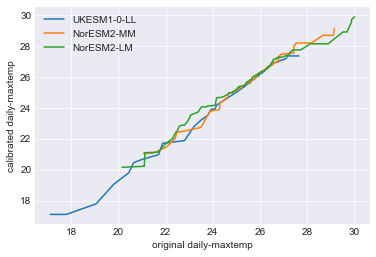

In [280]:
for model in best_models:
    cf = calibration_functions[model][0]
    unvars = np.sort(modvars[model][0][0])
    
    cf = calibration_functions[model][0][[round((i / unvars.size) * calibration_functions[model][0].size) for i in range(unvars.size)]]
    calvars = unvars[np.floor(cf * unvars.size).astype(np.int32)]
    
    
    plt.plot(unvars, calvars, label=model)
    plt.xlabel('original daily-maxtemp')
    plt.ylabel('calibrated daily-maxtemp')
    plt.legend()
plt.show()

In [263]:
modvars[model]

[array([[-9.847723388671852, -1.6677307128906023, 6.187402343750023, ...,
         9.542565917968773, 13.893792724609398, 13.292382812500023],
        [-2.7742370605468523, -1.4733947753906023, -0.6954101562499773,
         ..., 14.726586914062523, 10.661950683593773, 14.646356201171898],
        [8.479852294921898, 12.860772705078148, 14.782678222656273, ...,
         14.284112548828148, 17.932733154296898, 15.306146240234398],
        ...,
        [5.484796142578148, 5.122186279296898, 4.928033447265648, ...,
         22.402429199218773, 18.967309570312523, 17.412957763671898],
        [1.9348388671875227, 9.996453857421898, -0.10819091796872726, ...,
         16.585137939453148, 19.348870849609398, 20.176751708984398],
        [-1.6491455078124773, 0.41024169921877274, 2.0058837890625227,
         ..., 9.373803710937523, 19.275018310546898, 11.340722656250023]],
       dtype=object)]

In [252]:
for model in best_models:
    print(model)

UKESM1-0-LL
NorESM2-MM
NorESM2-LM


In [235]:
ofile.write('\t'.join(['indicator', 'event_thresh', 'location', 'best_models', 'historical_obs',
                       'historical_model_1', 'historical_model_2', 'historical_model_3',
                      'future_model_1', 'future_model_2', 'future_model_3',
                      'eventcount_or_prob_1', 'eventcount_or_prob_2', 'eventcount_or_prob_3']))
ofile.write('\n')


1

In [236]:
for indicator_key in list(indicators.keys()):
    indicator = indicators[indicator_key]
    for location in LOCATIONS:
        bests = list(allcounts[indicator['name']][location['name']]['future_mod'].keys())
        ofile.write('\t'.join([indicator['description'], str(TEST_THRESHOLDS[indicator['name']]), location['name'],
                               ' '.join(bests), str(allcounts[indicator['name']][location['name']]['hist_obs']).replace('\n',''),
                              str(allcounts[indicator['name']][location['name']]['hist_mod'][bests[0]]).replace('\n',''),
                              str(allcounts[indicator['name']][location['name']]['hist_mod'][bests[1]]).replace('\n',''),
                              str(allcounts[indicator['name']][location['name']]['hist_mod'][bests[2]]).replace('\n',''),
                              str(allcounts[indicator['name']][location['name']]['future_mod'][bests[0]]).replace('\n',''),
                              str(allcounts[indicator['name']][location['name']]['future_mod'][bests[1]]).replace('\n',''),
                              str(allcounts[indicator['name']][location['name']]['future_mod'][bests[2]]).replace('\n',''),
                              str(allresults[indicator['name']][location['name']][0][1]).replace('\n',''),
                              str(allresults[indicator['name']][location['name']][1][1]).replace('\n',''),
                              str(allresults[indicator['name']][location['name']][2][1]).replace('\n','')]))
        ofile.write('\n')

In [237]:
ofile.close()

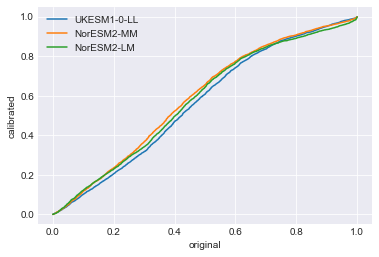

In [284]:
for model in best_models:
    cf = calibration_functions[model][0]
    plt.plot(np.array(range(len(cf)))/len(cf), cf, label=model)
    plt.xlabel('original')
    plt.ylabel('calibrated')
    plt.legend()
plt.show()

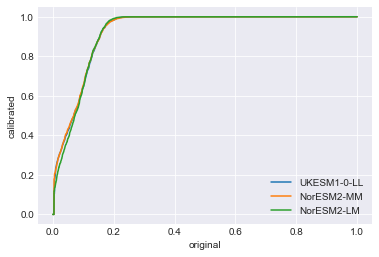

In [287]:
#precip
for model in best_models:
    cf = calibration_functions[model][0]
    plt.plot(np.array(range(len(cf)))/len(cf), cf, label=model)
    plt.xlabel('original')
    plt.ylabel('calibrated')
    plt.legend()
plt.show()

In [282]:
calibration_functions[model][0]

array([1.70068027e-04, 3.40136054e-04, 6.80272109e-04, ...,
       9.98469388e-01, 9.98979592e-01, 9.99319728e-01])